 **Importing packages for detection and plotting**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import neo

**Reading the abf file**

In [3]:
r = neo.io.AxonIO(r"C:\Users\yadun\Desktop\18226001_VC.abf")
print(r)

AxonIO: C:\Users\yadun\Desktop\18226001_VC.abf
nb_block: 1
nb_segment:  [1]
signal_streams: [Signals (chans: 2)]
signal_channels: [IN0, IN1]
spike_channels: []
event_channels: [Tag]



**Reading blocks**

In [4]:
blk = r.read_block() #read the block structure of the abf file with neo
blk

Block with [<neo.core.segment.Segment object at 0x00000274EAD19D80>] segments, [<neo.core.group.Group object at 0x00000274EAD19D50>, <neo.core.group.Group object at 0x00000274EAD1A1A0>] groups
annotations: {'abf_version': 2.0}
file_origin: 'C:\\Users\\yadun\\Desktop\\18226001_VC.abf'
rec_datetime: datetime.datetime(2018, 2, 26, 18, 1, 38, 983999)
# segments (N=[<neo.core.segment.Segment object at 0x00000274EAD19D80>])
0: Segment with [<AnalogSignal(array([[-24.41406 ],
       [-18.310547],
       [-20.751951],
       ...,
       [ 38.45215 ],
       [ 41.503902],
       [ 40.2832  ]], dtype=float32) * pA, [0.0 s, 300.0 s], sampling rate: 20000.0 Hz)>, <AnalogSignal(array([[ 0.00643921],
       [ 0.00576782],
       [ 0.00536194],
       ...,
       [-0.00400696],
       [-0.00365601],
       [-0.00382385]], dtype=float32) * mV, [0.0 s, 300.0 s], sampling rate: 20000.0 Hz)>] analogsignals, [<Event: >] events
   annotations: {'abf_version': 2.0}
   # analogsignals (N=[<AnalogSignal(array

**Reading segments**

In [5]:
seg = r.read_segment() #read segments nested inside each block. For more info about abf filesystems, check out neo documentation!
seg

Segment with [<AnalogSignal(array([[-24.41406 ],
       [-18.310547],
       [-20.751951],
       ...,
       [ 38.45215 ],
       [ 41.503902],
       [ 40.2832  ]], dtype=float32) * pA, [0.0 s, 300.0 s], sampling rate: 20000.0 Hz)>, <AnalogSignal(array([[ 0.00643921],
       [ 0.00576782],
       [ 0.00536194],
       ...,
       [-0.00400696],
       [-0.00365601],
       [-0.00382385]], dtype=float32) * mV, [0.0 s, 300.0 s], sampling rate: 20000.0 Hz)>] analogsignals, [<Event: >] events
annotations: {'abf_version': 2.0}
# analogsignals (N=[<AnalogSignal(array([[-24.41406 ],
       [-18.310547],
       [-20.751951],
       ...,
       [ 38.45215 ],
       [ 41.503902],
       [ 40.2832  ]], dtype=float32) * pA, [0.0 s, 300.0 s], sampling rate: 20000.0 Hz)>, <AnalogSignal(array([[ 0.00643921],
       [ 0.00576782],
       [ 0.00536194],
       ...,
       [-0.00400696],
       [-0.00365601],
       [-0.00382385]], dtype=float32) * mV, [0.0 s, 300.0 s], sampling rate: 20000.0 Hz)>])
0

**Extract spike trace**

In [6]:
ec_trace = np.ravel(seg.analogsignals[0].magnitude) #ec: Eurydendroid cells
ec_trace

array([-24.41406 , -18.310547, -20.751951, ...,  38.45215 ,  41.503902,
        40.2832  ], dtype=float32)

**Extract time trace**

In [7]:
fs = 20000 # Sampling rate in Hz
exp_duration = 300
time_trace= np.linspace(seg.t_start.magnitude, seg.t_stop.magnitude, fs*exp_duration) #(start,end,stepsize(fs*duration))
time_trace

array([0.00000000e+00, 5.00000083e-05, 1.00000017e-04, ...,
       2.99999900e+02, 2.99999950e+02, 3.00000000e+02])

**Plot the two traces**

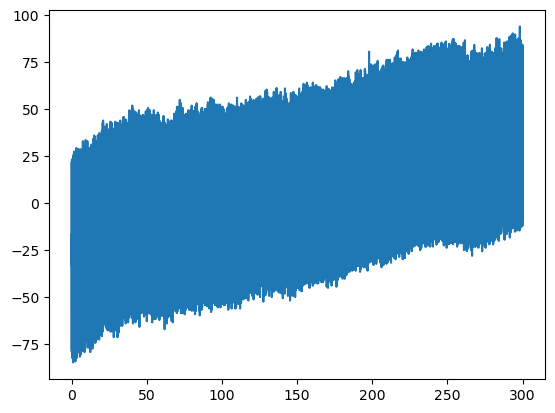

In [8]:
plt.plot(time_trace, ec_trace)

As you can see, there is a baseline shift in the recording over time. To get rid of this and to normalize the baseline, we can do a bandpass filter!

**If baselne shift present define the frequency range for the bandpass filter**

In [9]:
lowcut = 200 # Lower cutoff frequency in Hz(200hz = 500ms, decided by changing distance in find.peaks.(anything below 500 will get cut off))
highcut = 2500 # Upper cutoff frequency in Hz, if there are artefacts in the spike plot, change around the value to eliminate them

# Design the bandpass filter
nyq = 0.5 * fs #nyquist
low = lowcut / nyq
high = highcut / nyq
order = 4
b, a = scipy.signal.butter(order, [low, high], btype='band')

#filter the signal
ec_trace_new = -(scipy.signal.filtfilt(b, a, ec_trace)) #(-ec_trace here because the spike starts as a trough)

**Check the efficiency of the filtering**

(-94.83885955810547, 103.99413299560547)

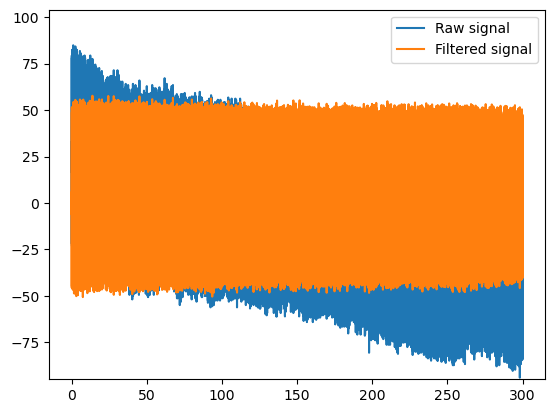

In [10]:
plt.plot(time_trace, -(ec_trace), label='Raw signal')
plt.plot(time_trace, ec_trace_new, label='Filtered signal')
plt.legend()
plt.ylim(np.min(ec_trace)-10, np.max(ec_trace)+10)

**To detect actual spikes, input cutoff height**

In [11]:
threshold = int(input('Enter threshold')) # threshold for spike detection varies according to the recording!

**Detect spikes**

In [12]:
min_isi_ms = 2 #obtained by taking mininum of np.diff of peak_idxs in time_trace, hence giving interspike interval
peak_idxs, peak_amplitude = scipy.signal.find_peaks(ec_trace_new, height = threshold, distance = (min_isi_ms/1000)*fs)
peak_idxs, peak_amplitude

(array([   2185,    3818,    5853, ..., 5995367, 5998300, 5999324],
       dtype=int64),
 {'peak_heights': array([51.49213067, 48.82977773, 50.29428639, ..., 46.60152194,
         47.48285547, 44.3276898 ])})

**Plot the detected peaks with the ec_trace**

(-60.61393196485153, 67.70164237773338)

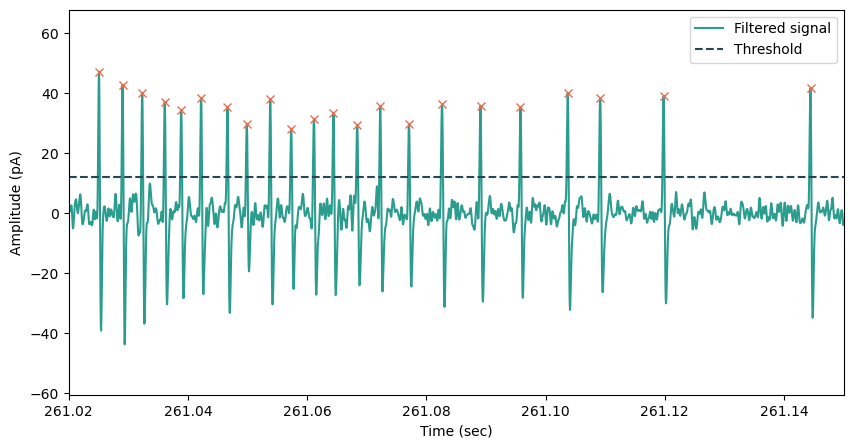

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(time_trace, ec_trace_new, '#2a9d8f', label='Filtered signal')
plt.axhline(threshold, color = '#264653',linestyle='--', label='Threshold')
plt.plot(time_trace[peak_idxs], ec_trace_new[peak_idxs], "x", color = '#e76f51')
plt.legend()
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude (pA)')
plt.xlim(261.02,261.15)
plt.ylim(np.min(ec_trace_new)-10, np.max(ec_trace_new)+10)


**Plot a histogram of np.diff of timepoints of peak idxs to know whats the avg interspike interval**

0.002800000466720576

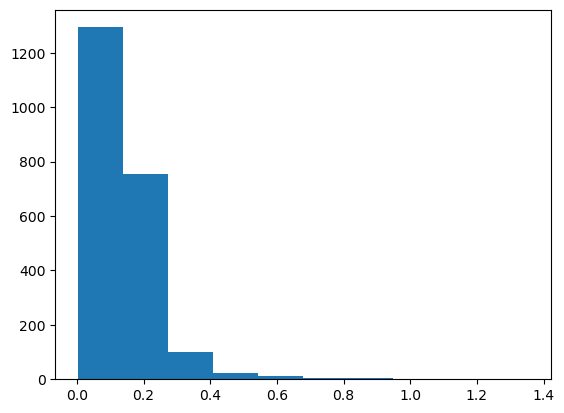

In [14]:
plt.hist(np.diff(time_trace[peak_idxs]), bins = 10)

#find the min_isi to tweak the distance in find.peaks fn
np.min(np.diff(time_trace[peak_idxs]))

**Save the required arrays into a csv file**

In [15]:
data1 = time_trace[peak_idxs]
data2 = peak_idxs
np.savez(r"C:\Users\yadun\Desktop\spikes.npz", peak_times=data1, peak_idxs=data2)

Since we have data with spikes, let's extract fish motor data from the abf file

In [1]:
import os
import sys
from neo import io
import matplotlib.patches as patches
import pickle
from scipy import stats
%matplotlib inline
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

**Define functions to detect motor events**

In [2]:
def local_stdv(data,window):
    #Function adapted from: http://matlabtricks.com/post-20/calculate-standard-deviation-case-of-sliding-window
    ##this function finds the local standard deviation over an array with a sliding window
    W = window
    N = len(data)
    n = np.convolve(np.ones(N), np.ones(W), 'same')
    s = np.convolve(data, np.ones(W), 'same')
    q = data**2
    q = np.convolve(q, np.ones(W), 'same')
    o = (q-s**2/n)/(n-1)
    o = o**0.5

    return o


def local_avg(data,window):
    ## Function to find local average over a window
    mva = np.convolve(data,np.ones(window)/window,'same')
    return mva



def local_max(data, window):
    ## Function to find local maxima over a window
    localmax = np.zeros(len(data))
    for i in range(len(data)):
        start = max(0, i-window+1)
        end = i+1
        localmax[i] = np.max(data[start:end])
    return localmax


def episode_detect(data,min_thresh=0.0015,max_thresh=0.0015,
                   min_spacing=500,min_duration=500):
    
    ''' 
    This function identifies episodes in an array where the values exceed a certain threshold. it returns the start and end idxs of the episode, according 
    to the conditions that we set!
    '''

    start=np.array([0])
    end=np.array([0])
    toggle=0

    for i in np.arange(2,len(data)-min_spacing,1):

        if data[i]<min_thresh and data[i+1]>=min_thresh:
            if toggle==0:
                start=np.append(start,[i])
                toggle=1

        if data[i]>=min_thresh and all([values<min_thresh for values in data[i+1:i+min_spacing]]):
            if toggle==1:
                end=np.append(end,[i+1])
                toggle=0

    s=np.array([0])
    e=np.array([0])
    if len(start)>1 and len(end)>1:
        start=start[1::]
        end=end[1::]

        if len(start)>len(end):
            end=end[0::]
            start=start[0:len(end)]

        if len(start)<len(end):
            end=end[1::]
            start=start[0::]

        if start[0]==0:
            start=start[1::]
            end=end[1::]

        if max(end)==len(data)-min_spacing:
            end=end[0:len(end)-1]
            start=start[0:len(start)-1]

        thresh=max_thresh
        s1=np.array([0])
        e1=np.array([0])
        i=0
        for i in range(len(start)):
            if max(data[start[i]:end[i]])>thresh:
                s1=np.append(s1,start[i])
                e1=np.append(e1,end[i])
            i+=1

        s1=s1[1::]
        e1=e1[1::]

        duration = e1-s1

        for i in range(len(s1)):
            if duration[i]>=min_duration:
                s=np.append(s,s1[i])
                e=np.append(e,e1[i])

    s=s[1::]
    e=e[1::]

    return(s,e)


def peakdet(v, delta, x = None):
    """
    Adapted from: http://billauer.co.il/peakdet.html
    This function identifies the local minima (mintab) and maxima(maxtab) using the threshold (delta) that we provide!
    """
    maxtab = []
    mintab = []

    if x is None:
        x = np.arange(len(v))

    v = np.asarray(v)

    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')

    if not np.isscalar(delta):
        sys.exit('Input argument delta must be a scalar')

    if delta <= 0:
        sys.exit('Input argument delta must be positive')

    mn, mx = np.Inf, -np.Inf
    mnpos, mxpos = np.NaN, np.NaN

    lookformax = True

    for i in np.arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]

        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return np.array(maxtab), np.array(mintab)


def filter_peaks_by_spacing(peaks, minspacing):

    '''
    This function filters the peaks from a group of peaks based on a minimum interval between peaks(minspacing)
    '''

    peakindex = peaks[:,0]
    peakvalue = peaks[:,1]

    npeaks = len(peakindex)

    iterations = int(npeaks/2)+1

    for ii in range(iterations):

        filtered_peakindex = []
        filtered_peakvalue = []

        skip = False

        for i in range(npeaks-1):

            if skip == False:

                if peakindex[i+1]-peakindex[i] >= minspacing:
                    filtered_peakindex.append(peakindex[i])
                    filtered_peakvalue.append(peakvalue[i])
                    if i==npeaks-2:
                        filtered_peakindex.append(peakindex[i+1])
                        filtered_peakvalue.append(peakvalue[i+1])
                else:
                    skip = True
                    temp_peaks = np.array([peakvalue[i],peakvalue[i+1]])
                    thisornext = np.where(temp_peaks == max(temp_peaks))[0][0]
                    filtered_peakindex.append(peakindex[i+thisornext])
                    filtered_peakvalue.append(peakvalue[i+thisornext])
            else:
                skip = False

        peakindex = filtered_peakindex
        peakvalue = filtered_peakvalue
        npeaks = len(peakindex)

    filtered_peaks = np.transpose(np.vstack((filtered_peakindex,filtered_peakvalue)))

    return filtered_peaks


def reject_peaks_outside_event(peaks,episode_timing):
    '''
    This function rejects peaks that are outside a given window, which we can use to filter out random swims/peaks outside an episode!
    '''

    peaktime = peaks[:,0]
    peakvalue = peaks[:,1]
    selected_peaktime = []
    selected_peakvalue = []
    for i in range(len(peaktime)):
        if peaktime[i] >= episode_timing[0] and peaktime[i] <= episode_timing[1]:
            selected_peaktime.append(peaktime[i])
            selected_peakvalue.append(peakvalue[i])

    selected_peaks = np.transpose(np.vstack((selected_peaktime,selected_peakvalue)))

    return selected_peaks


def filter_indices_by_spacing(indices, minspacing):
    '''
    This function can be used to filter consecutive indices by a minspacing
    '''

    n = len(indices)
    iterations = int(n/2)+1

    for ii in range(iterations):

        filtered_indices = []
        skip = False

        for i in range(n-1):

            if skip == False:

                if indices[i+1]-indices[i] >= minspacing:
                    filtered_indices.append(indices[i])
                    if i==n-2:
                        filtered_indices.append(indices[i+1])
                else:
                    skip = True
                    filtered_indices.append(indices[i])
            else:
                skip = False

        indices = filtered_indices
        n = len(indices)

    return filtered_indices

**Input parameters**

In [3]:
filename = r"C:\Users\yadun\Desktop\18226001_VC.abf"

channels = 2 # number of acquisition channels used
ch_id = ['ec_recording', 'motor'] # identity of each channel in the correct order

sampling_rate = 20000 #Hz
auto_threshold = True
threshold = 0.002 #units: mV, standard deviation threshold for motor event detection
max_threshold = 0.0035 #units: mV, max standard deviation within episode must be greater than this value
minimum_interval = 100 #units: ms, minimum inter episode interval
minimum_duration = 50 #units: ms, minimum episode duration
local_stdv_window = 5 #units: ms, window for local standard deviation calculation
smoothing_window = 10 #units: ms, window for moving average smoothing of stdv trace

min_burst_interval = 25 #units: ms, minimum interval between bursts within an episode
burst_detection_threshold = 0.001#units: mV, peakdet threshold

**Unit conversions**

In [4]:
minimum_interval = int(minimum_interval*sampling_rate/1000)
minimum_duration = int(minimum_duration*sampling_rate/1000)
local_stdv_window = int(local_stdv_window*sampling_rate/1000)
smoothing_window = int(smoothing_window*sampling_rate/1000)

min_burst_interval = min_burst_interval/1000 #in seconds

**Read abf files**

In [5]:
r = io.AxonIO(filename = filename)
b = r.read_block(lazy=False)

analogsignals = b.segments[0].analogsignals

**Extract data from the available channels**

In [6]:
traces = []

for c in range(channels):
    t = analogsignals[c]
    t = np.ravel(np.array(t))

    traces.append(t)

axondata = dict(zip(ch_id, traces))

motor = axondata['motor']
timeaxis = np.arange(0,len(motor)/sampling_rate,1/sampling_rate)

**Automatic thresholding**

In [7]:
motor_stdv = local_stdv(motor,local_stdv_window)
median_stdv = np.median(motor_stdv)
tenth_prctl = np.percentile(motor_stdv,10)
motor_stdv = motor_stdv-tenth_prctl #to lower the variability in the signal and bring out higher deviations

if auto_threshold:
    motor_env = local_max(motor_stdv,500)
    threshold = np.median(motor_env)*1.5
    max_threshold = threshold*1.5

# Detect swim episodes

episodes = episode_detect(motor_stdv,threshold,max_threshold,minimum_interval,
                          minimum_duration)

episode_duration = (episodes[1]-episodes[0])/sampling_rate
nepisodes = len(episode_duration)
print(nepisodes)

19


**Visualize thresholding**

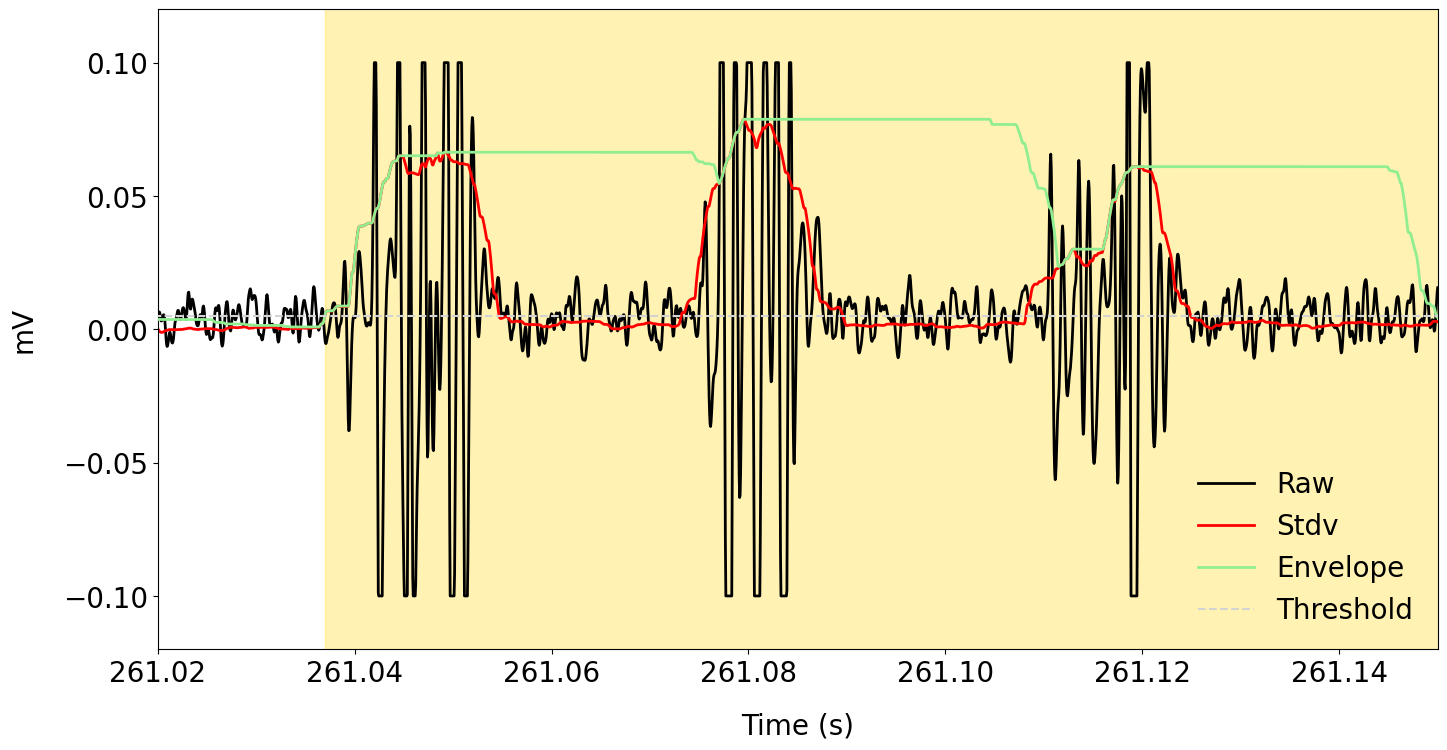

In [8]:
fig1 = plt.figure(figsize=[16,8])
ax1 = fig1.add_axes([.14,.12,.8,.8])

ax1.plot(timeaxis,motor,color='black',linewidth=2,label='Raw')
ax1.plot(timeaxis,motor_stdv,color='red',linewidth=2,label='Stdv')

if auto_threshold:
    ax1.plot(timeaxis,motor_env,linewidth=2,color='lightgreen',zorder=3,label='Envelope')
plt.hlines(threshold,0,max(timeaxis),linestyle='--',color='lightgrey',zorder=4,label='Threshold')

for i in range(nepisodes):
    ax1.add_patch(patches.Rectangle((episodes[0][i]*1/sampling_rate,-1),
                  episode_duration[i]*1,2,
                  facecolor='gold',alpha=0.3,edgecolor='gold',zorder=0))

# ax1.set_xlim(min(timeaxis),max(timeaxis))
ax1.set_xlim(261.02,261.15)
ax1.set_ylim(-(0.12),0.12)


ax1.set_xlabel('Time (s)',fontsize=20,labelpad=18)
ax1.set_ylabel('mV',fontsize=20,labelpad=18)

ax1.legend(frameon = False , fontsize = 20, loc = 'lower right')

**Event statistics**

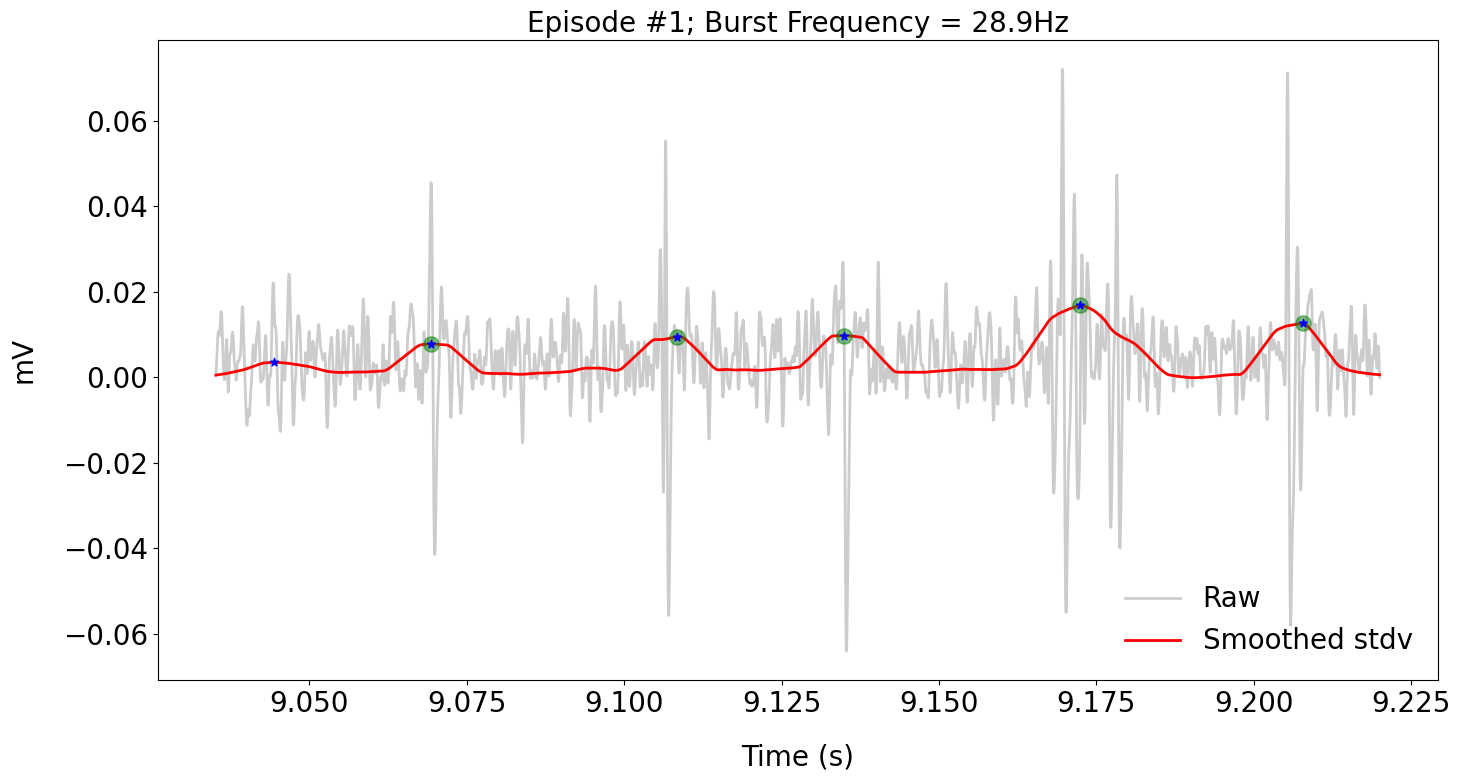

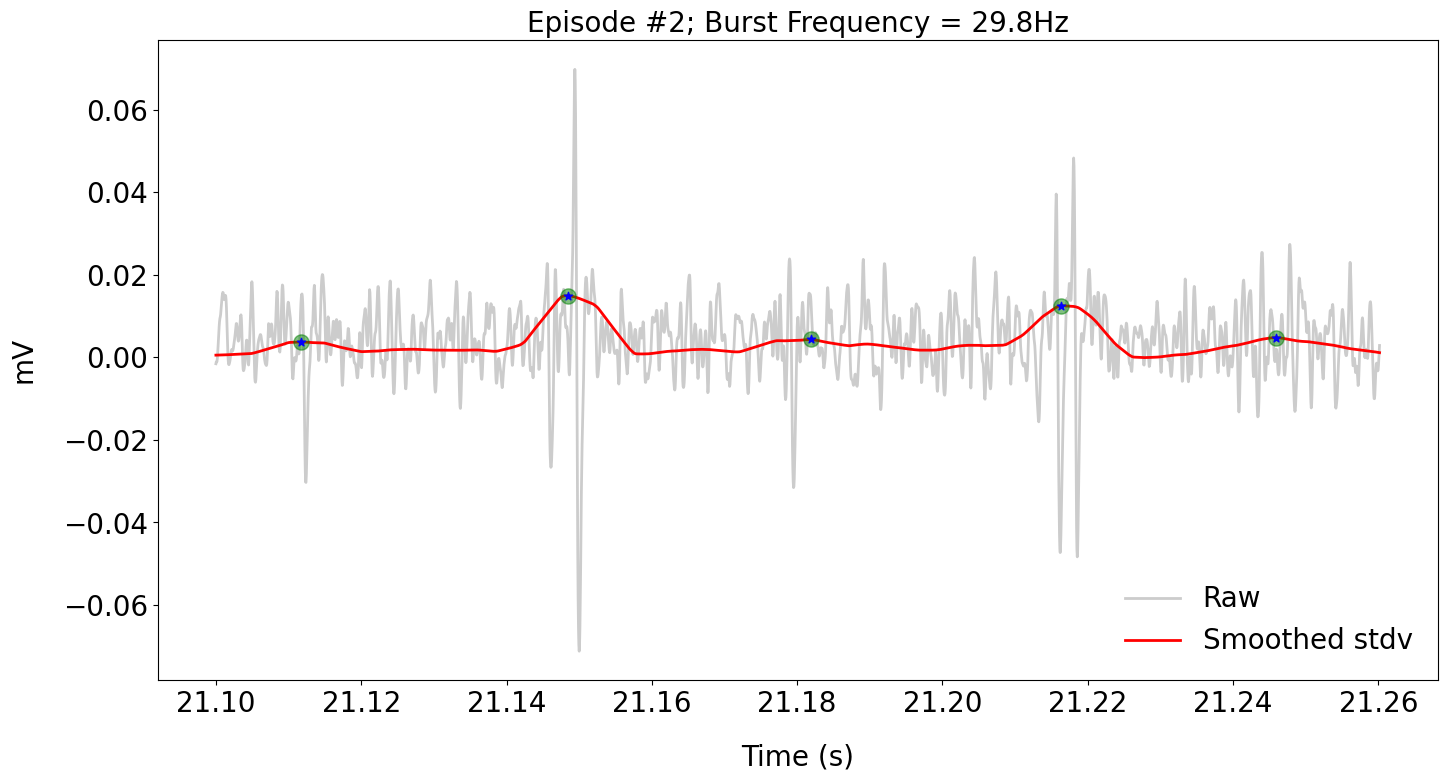

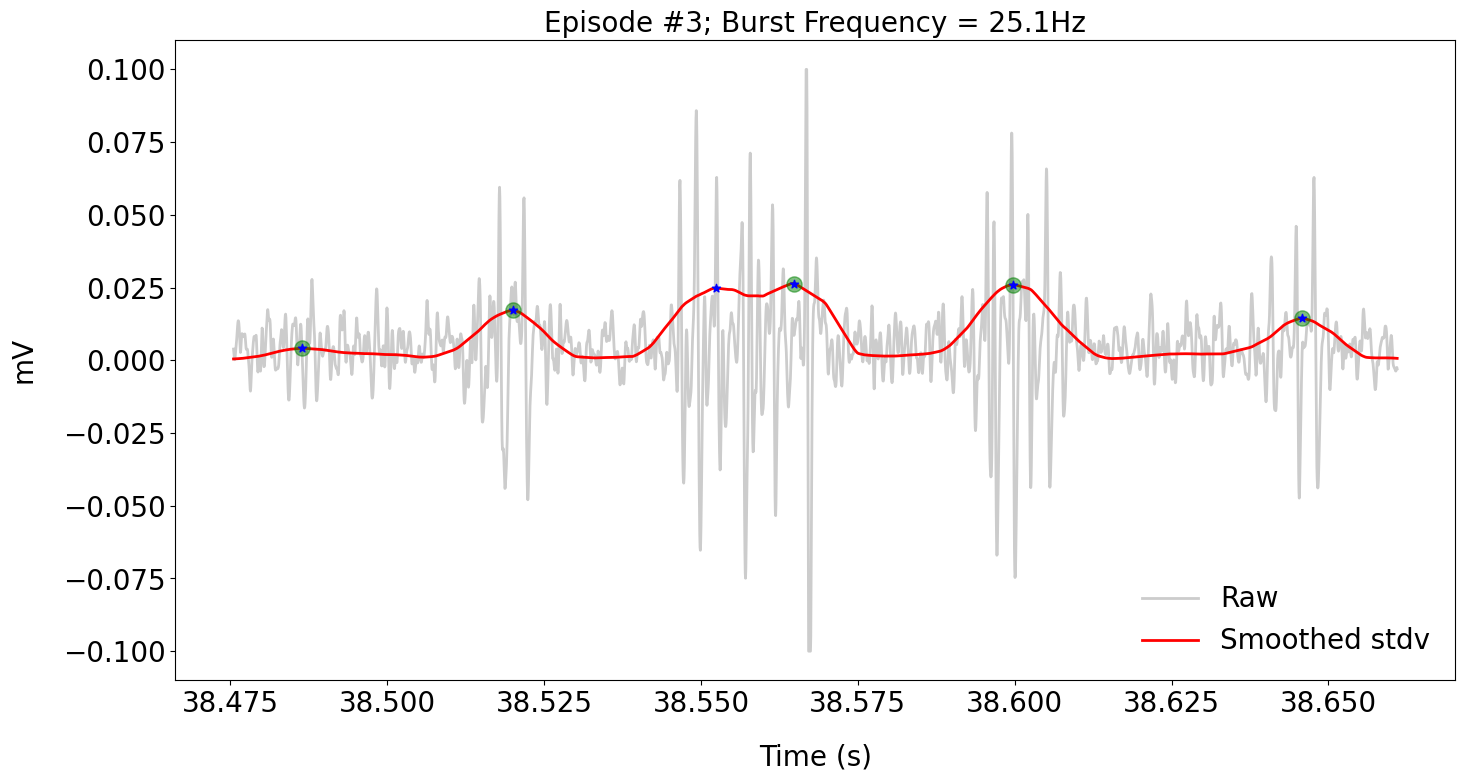

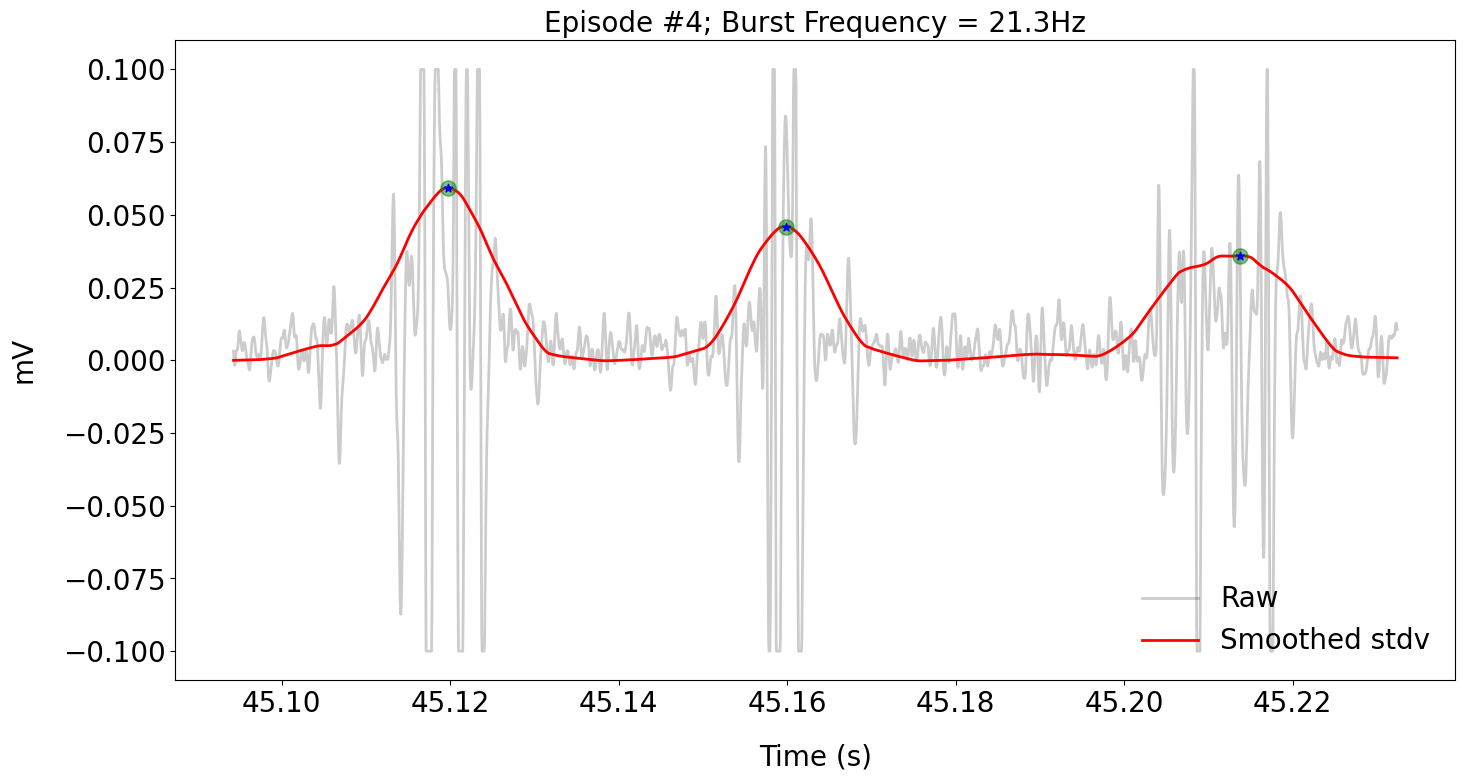

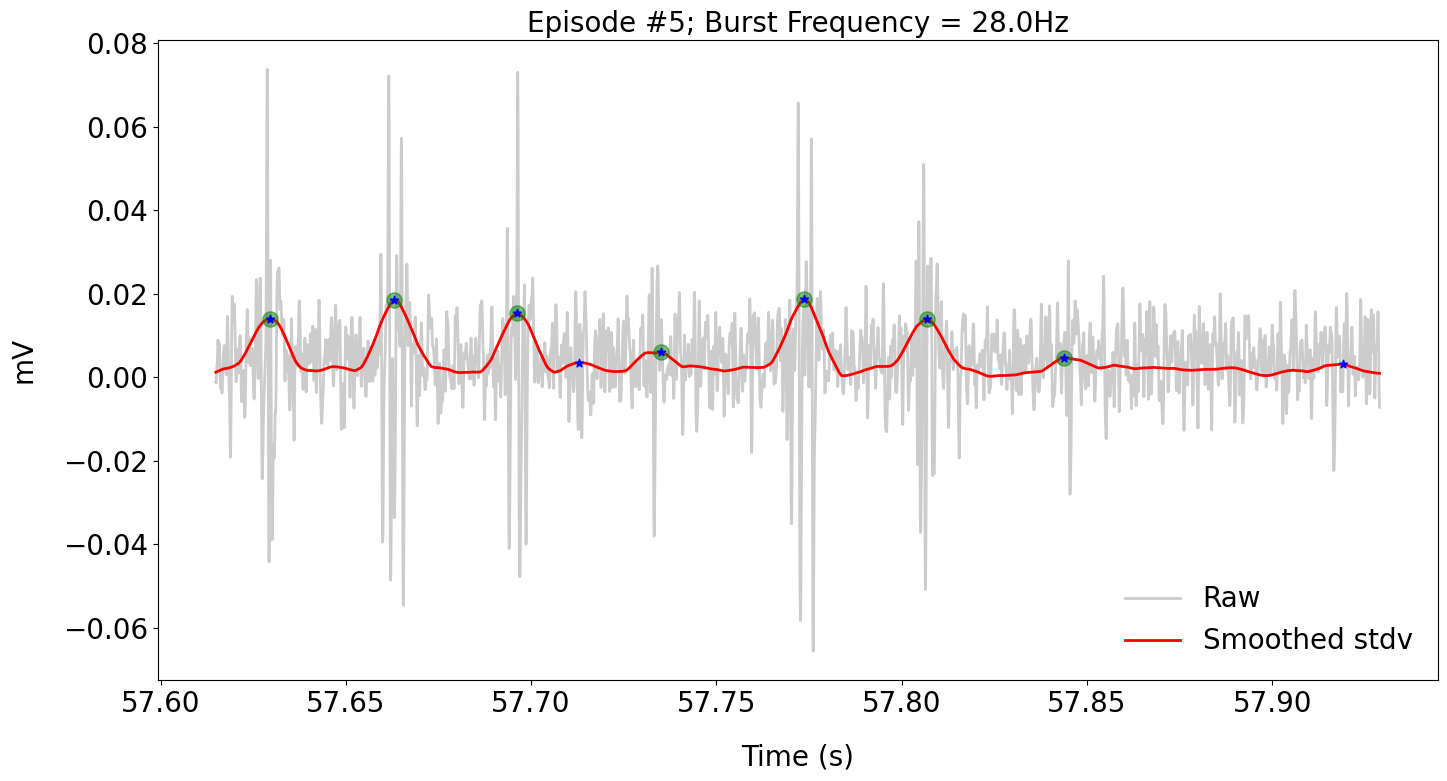

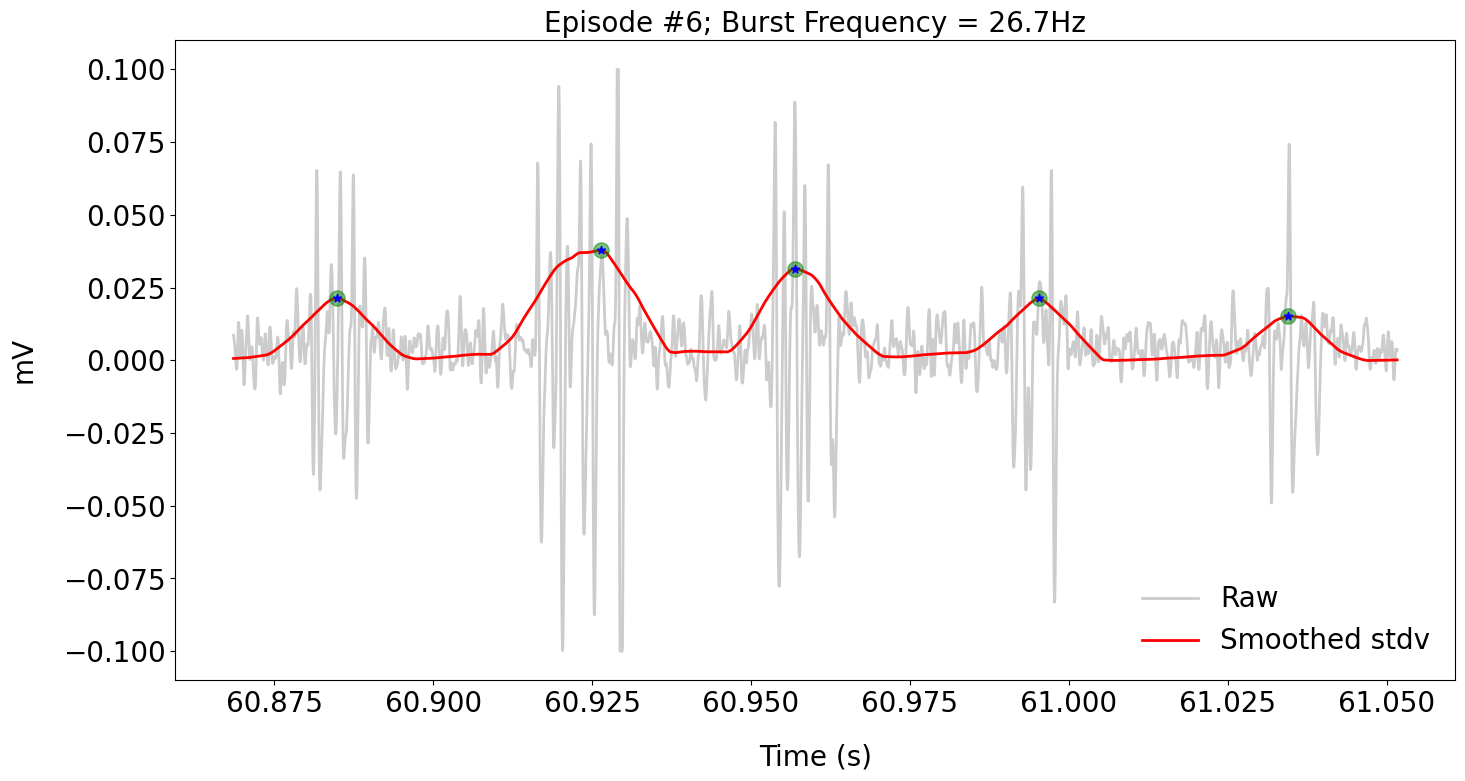

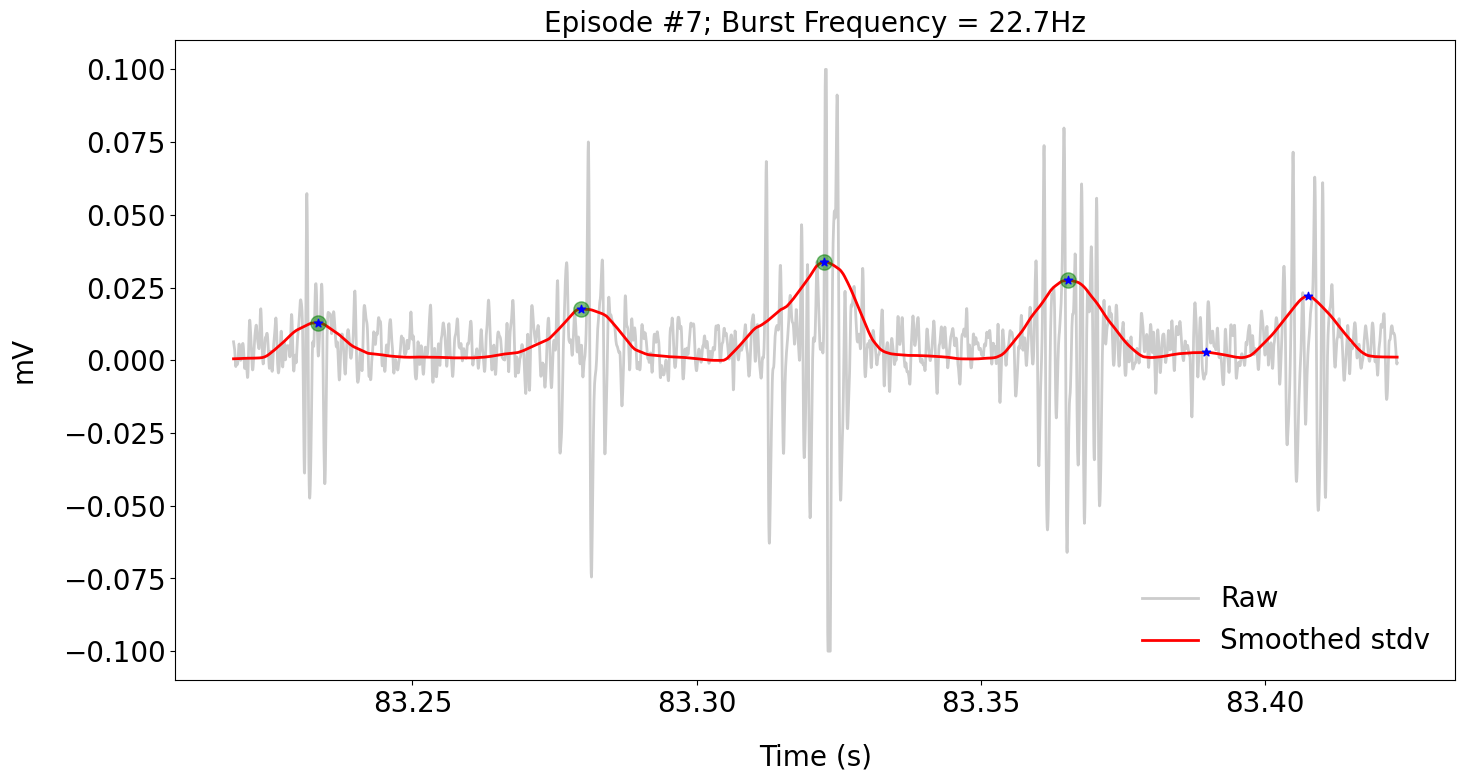

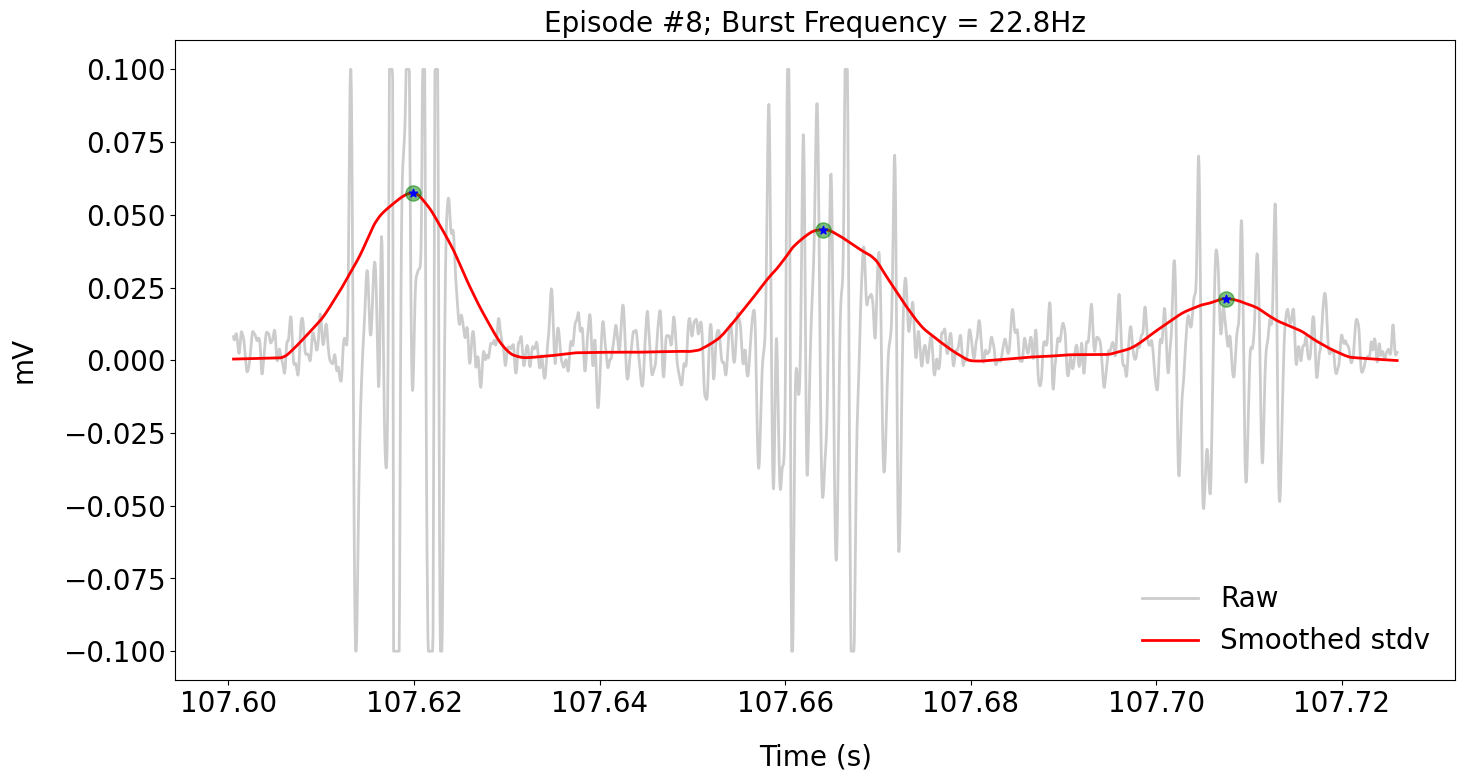

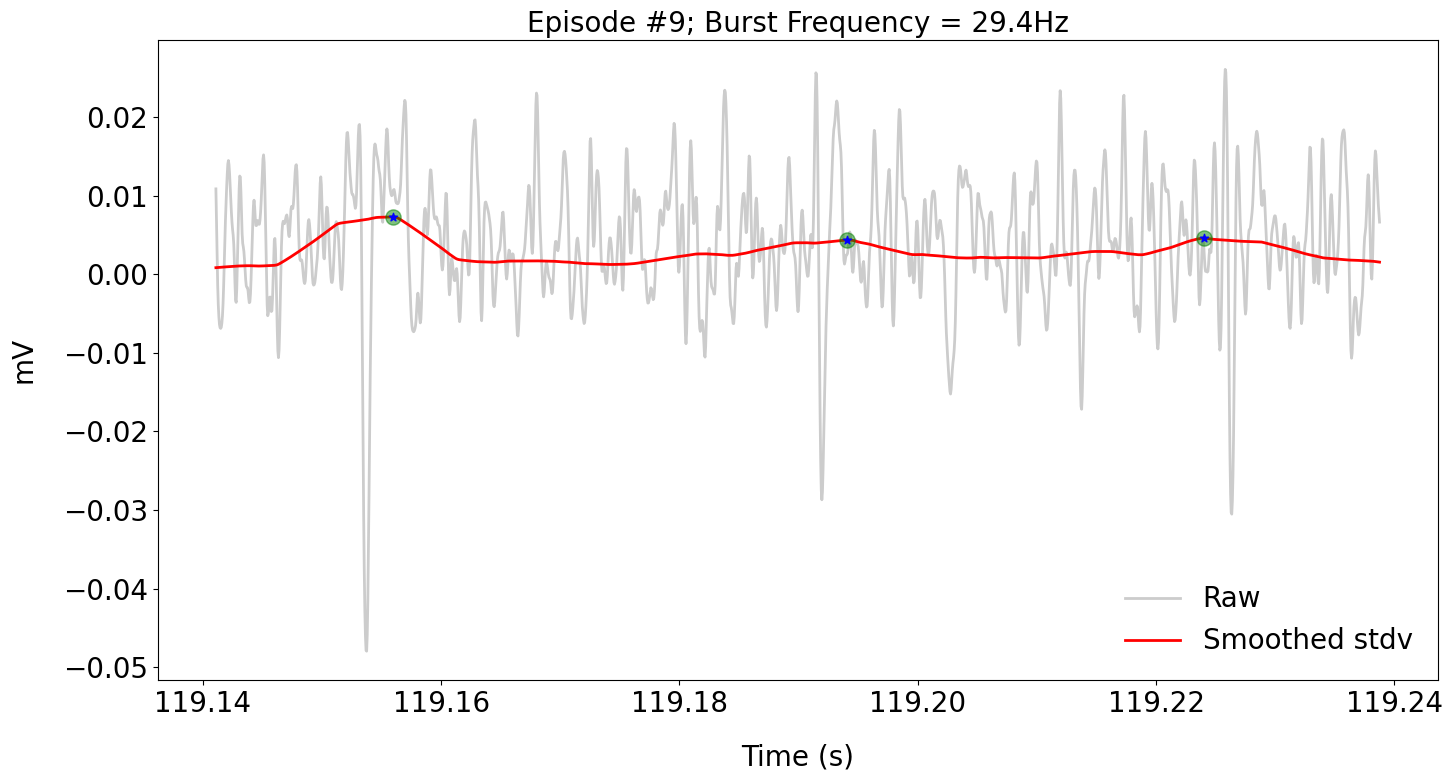

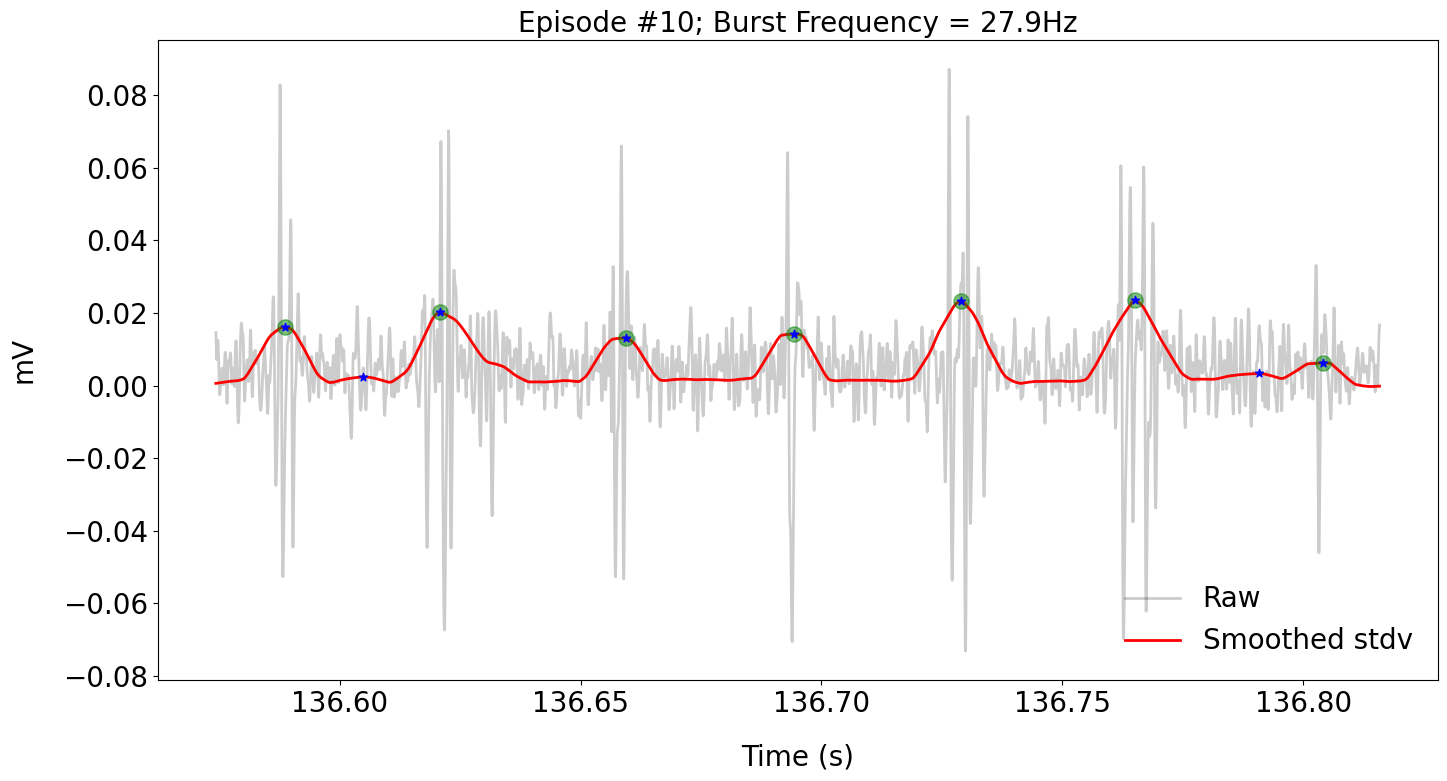

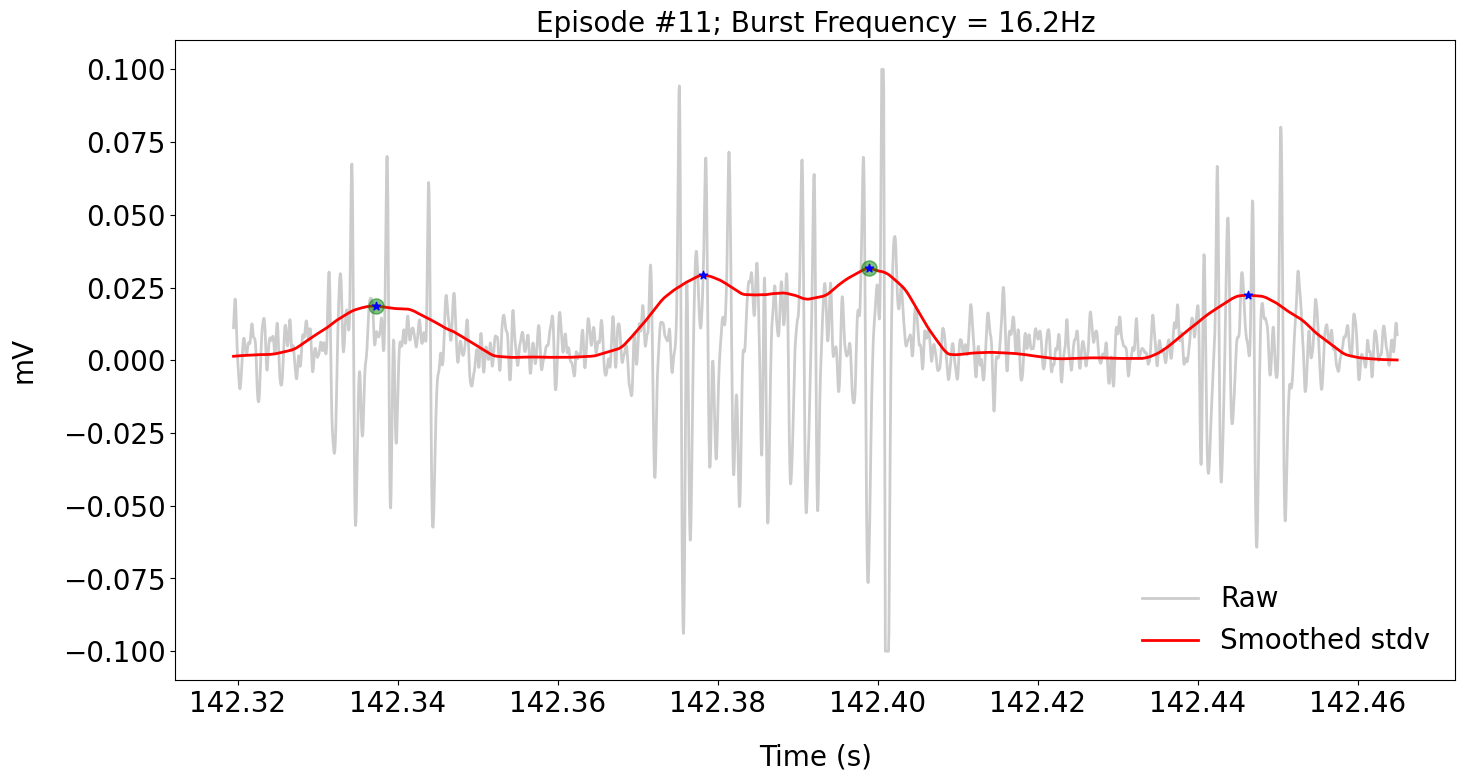

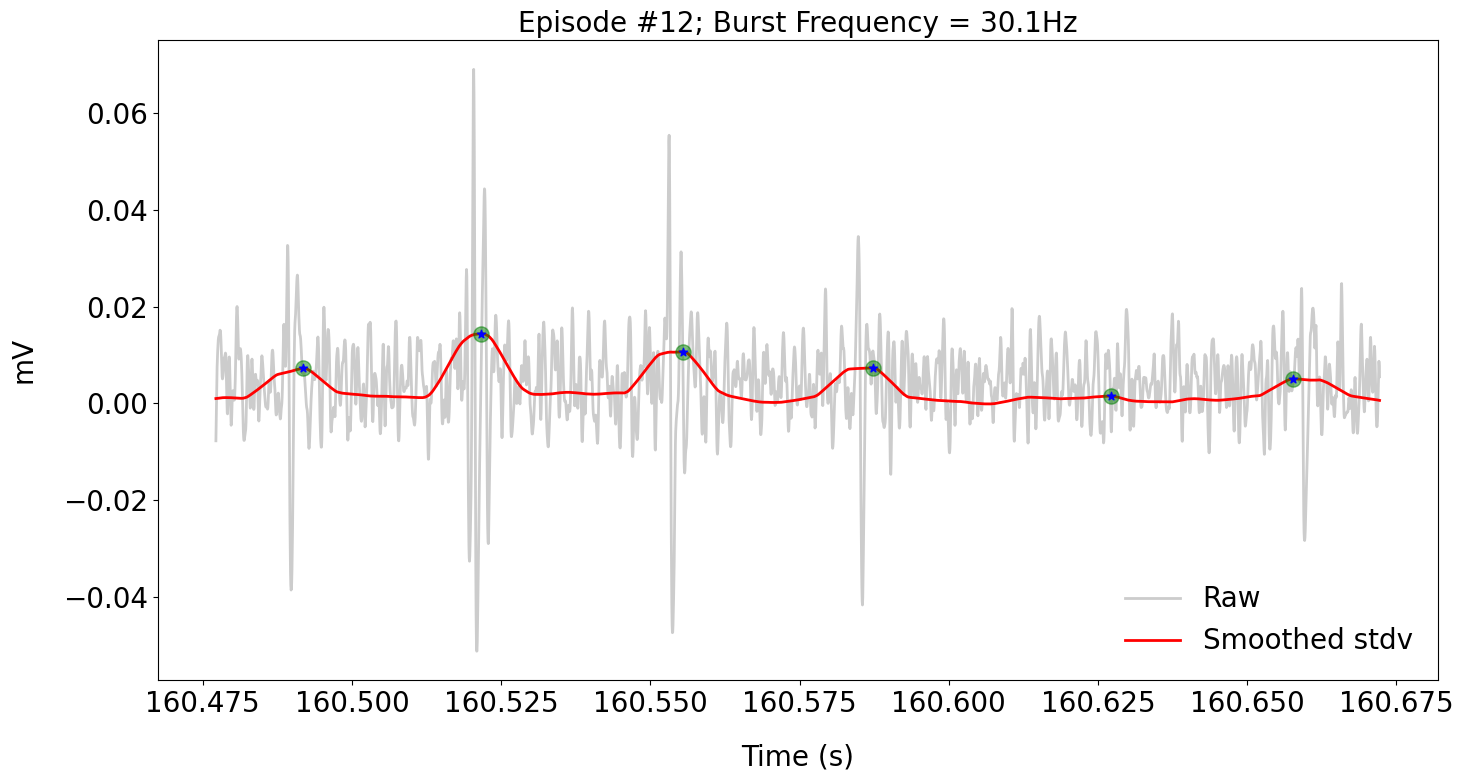

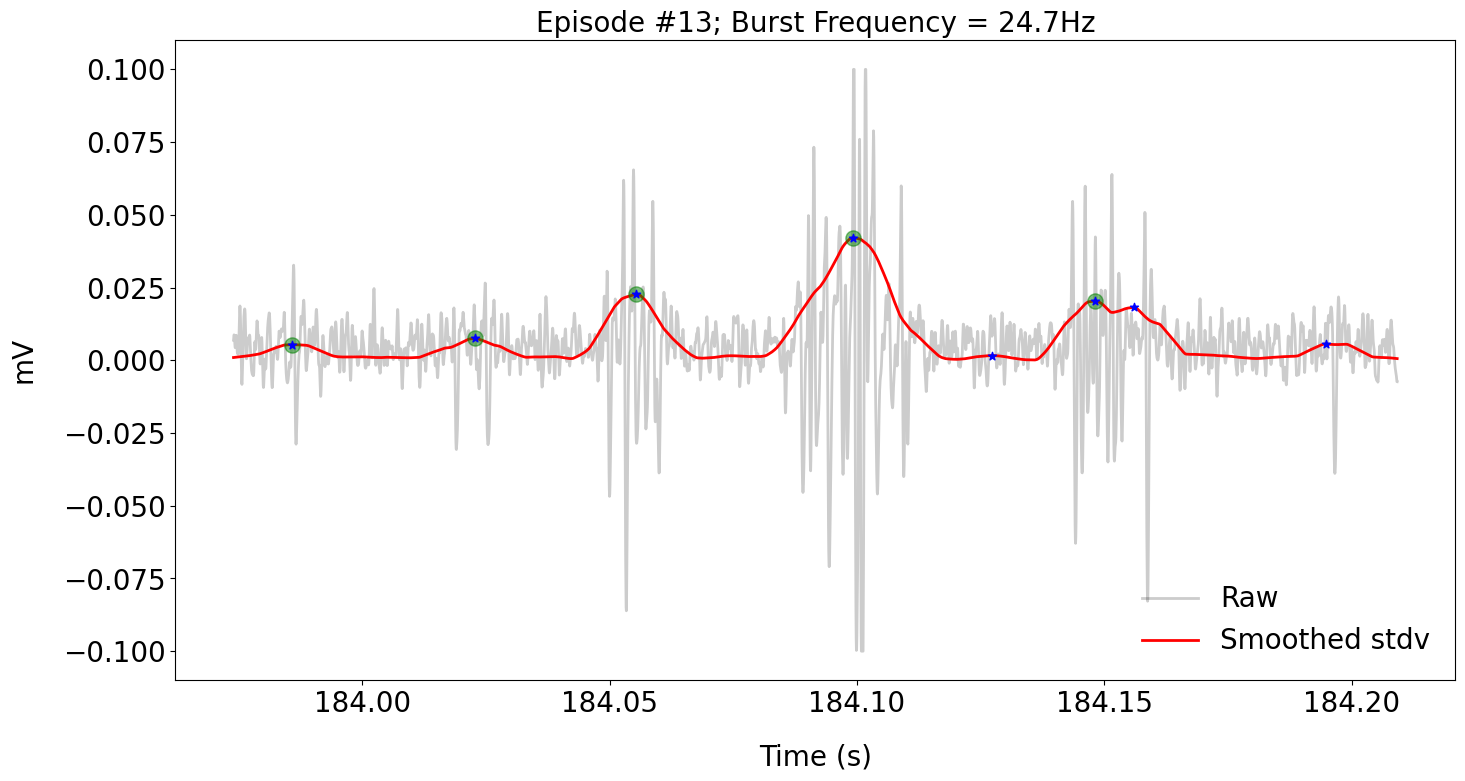

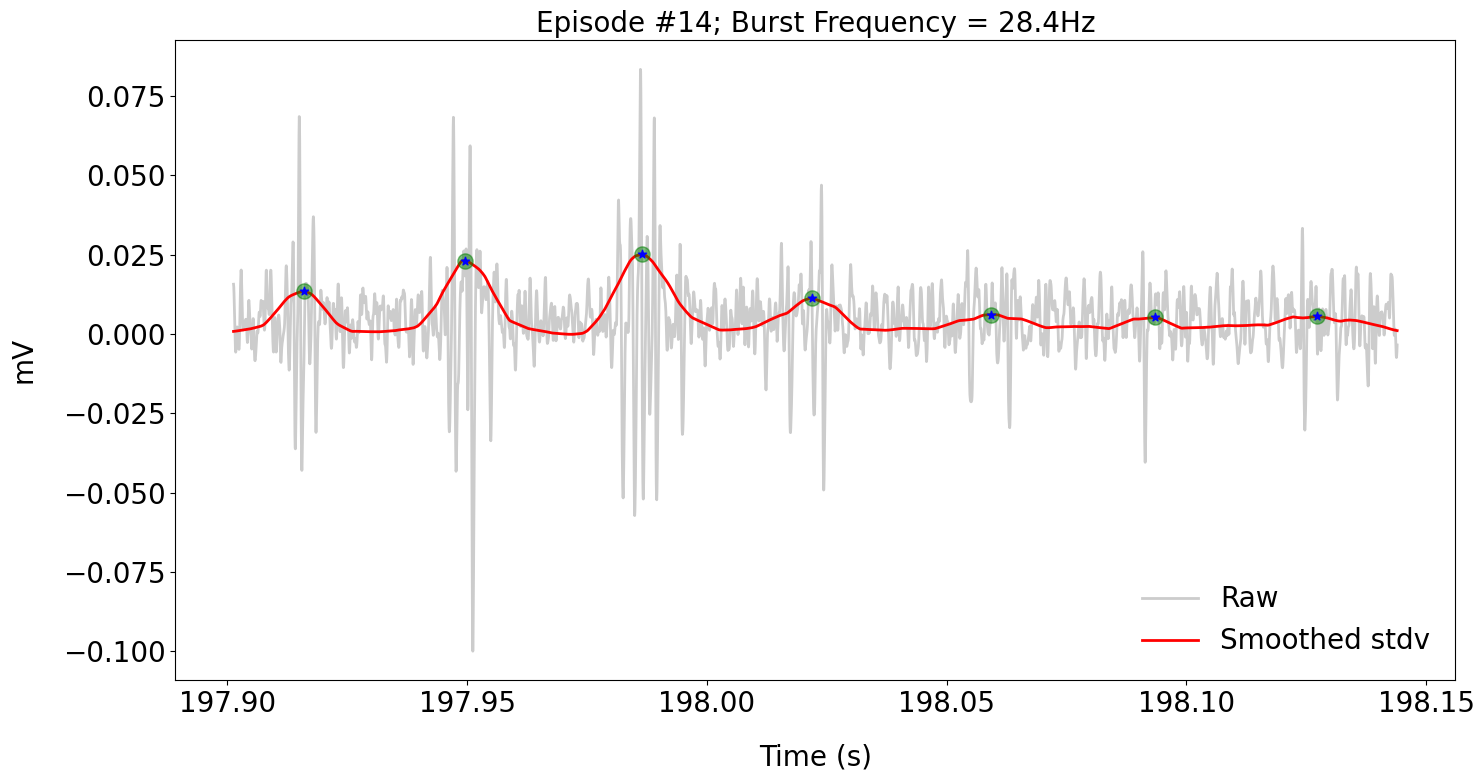

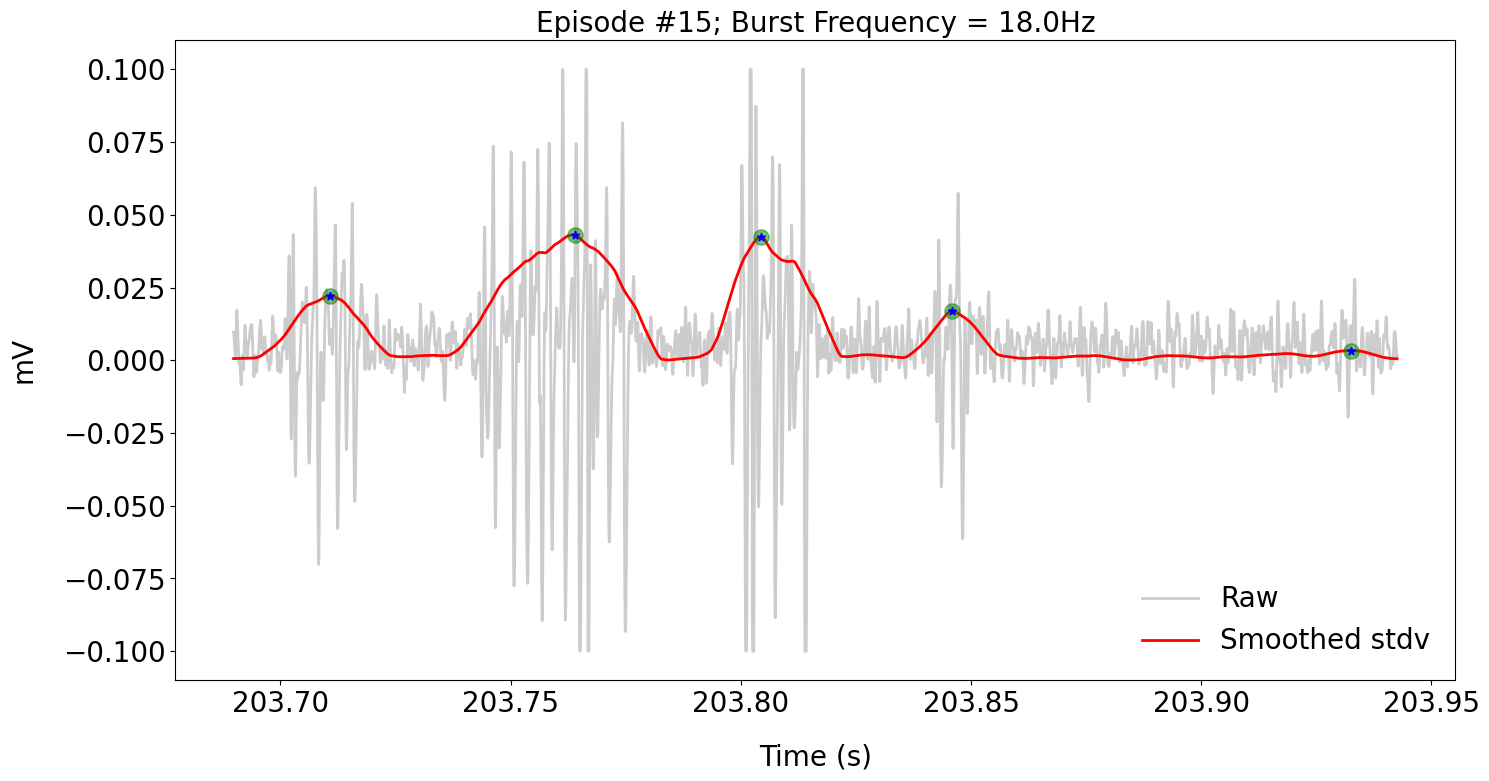

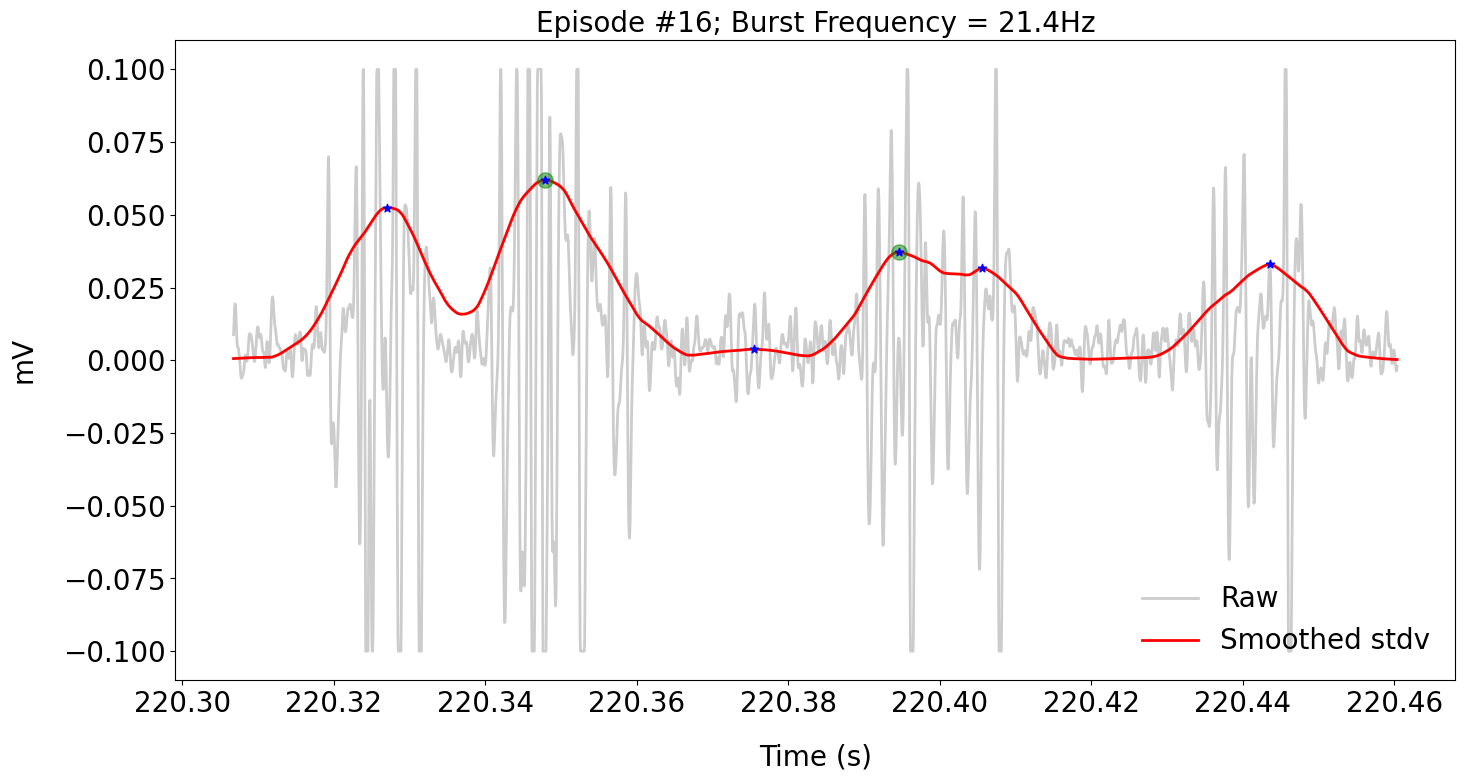

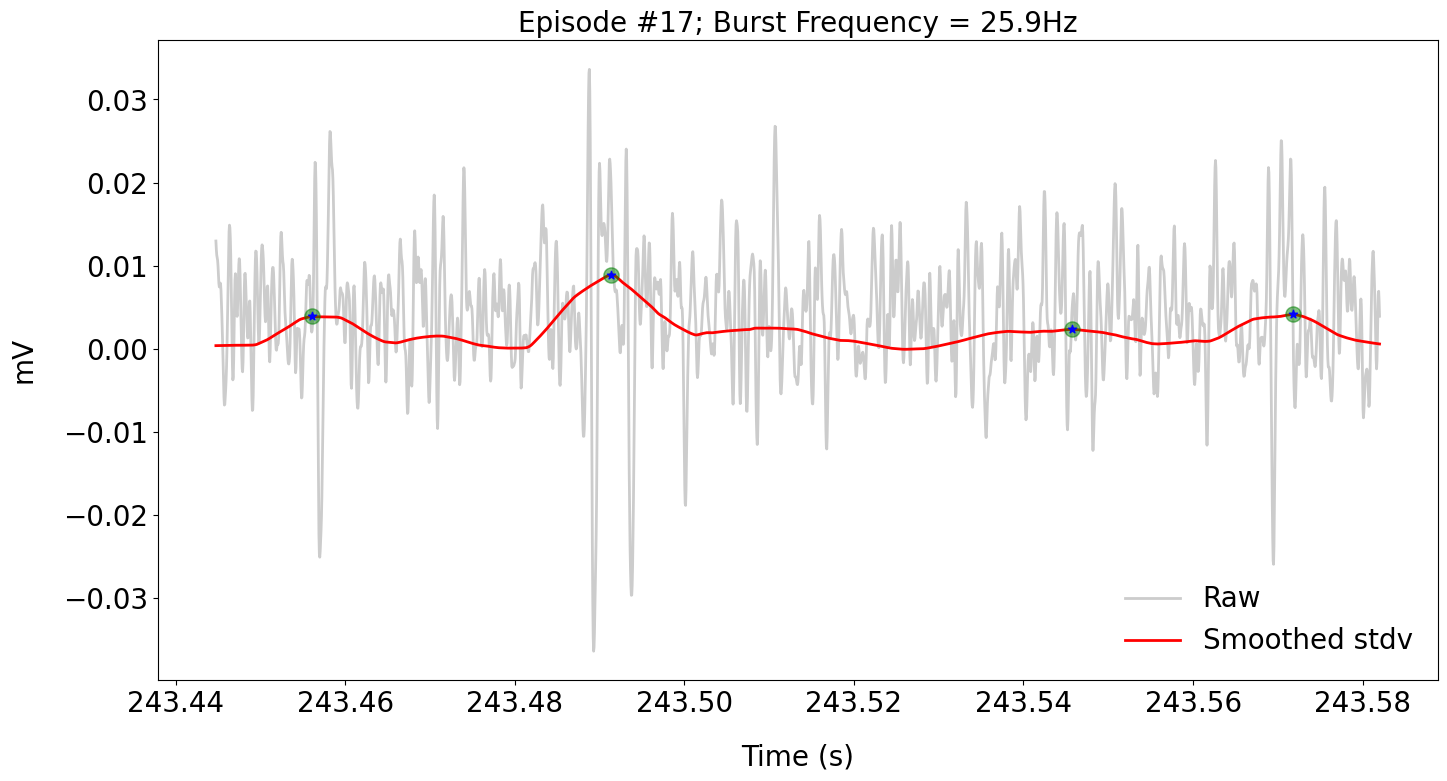

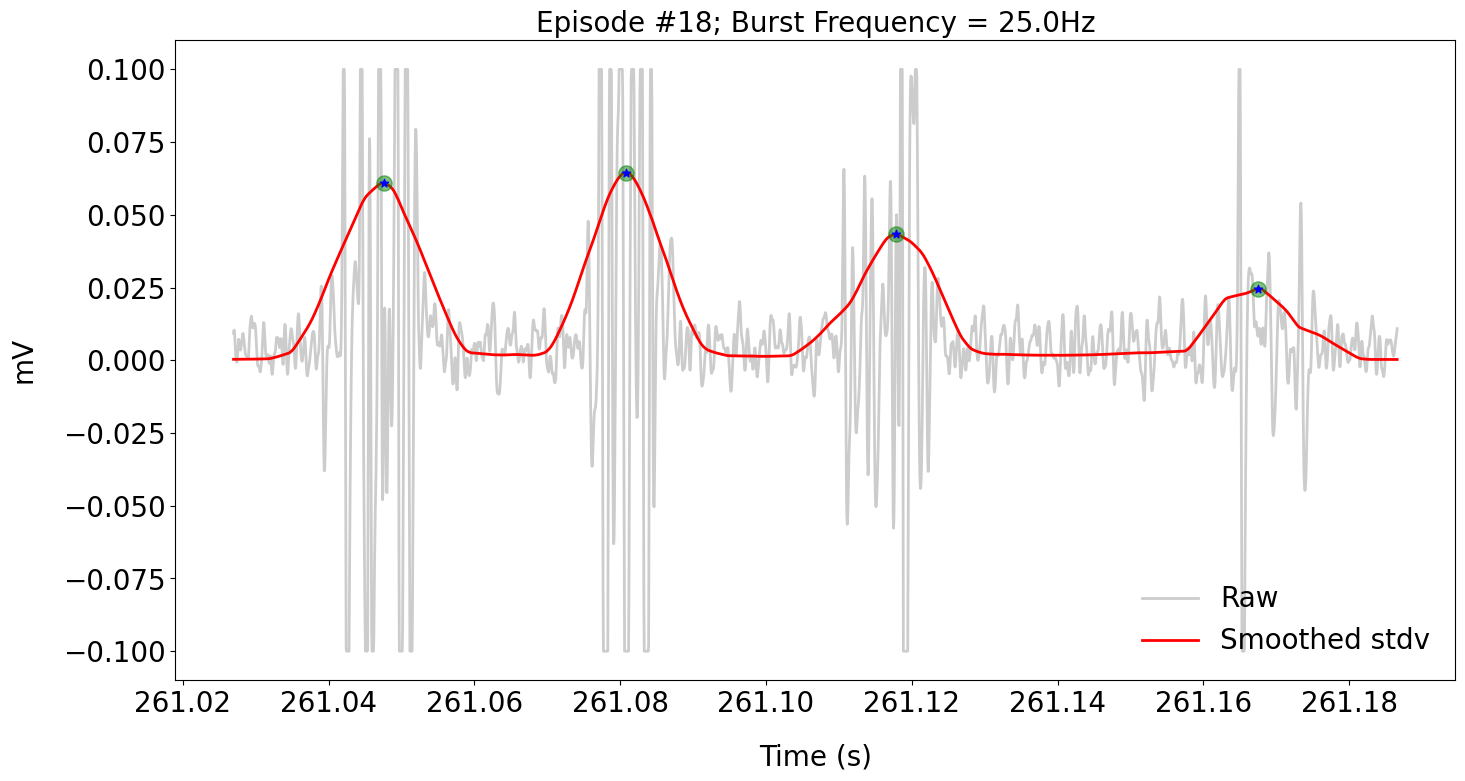

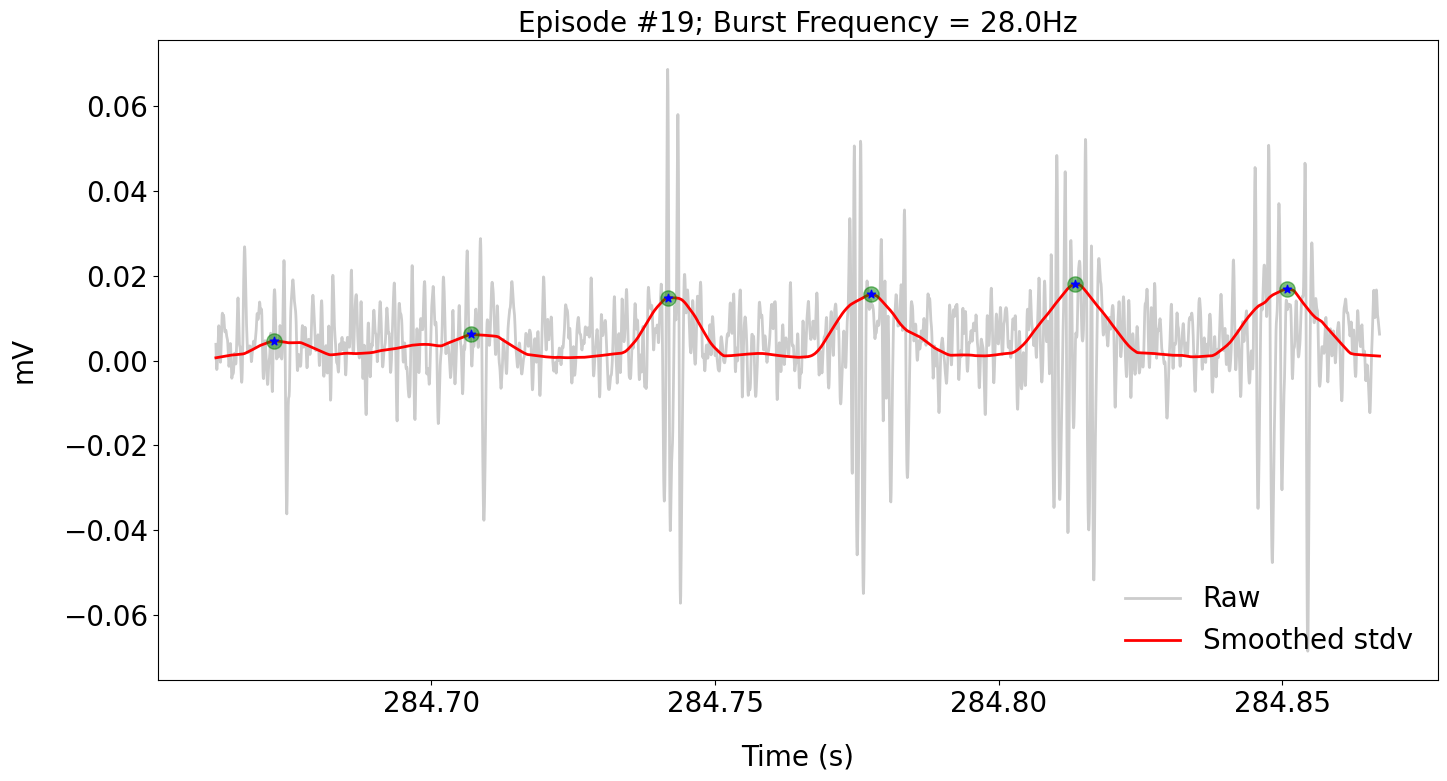

In [9]:
cropped_events = []
nbursts = []
burst_frequency = []
episode_strength = []

if nepisodes > 0:
    for i in range(nepisodes):

        if episodes[0][i] > smoothing_window and episodes[1][i]+smoothing_window < len(motor_stdv):
            temp_event = motor_stdv[episodes[0][i]-smoothing_window:episodes[1][i]+smoothing_window]
            temp_event = local_avg(temp_event,smoothing_window)
            cropped_axis = np.arange(timeaxis[episodes[0][i]-smoothing_window],timeaxis[episodes[1][i]+smoothing_window]+(len(temp_event))/sampling_rate,1/sampling_rate)
            cropped_axis = cropped_axis[0:len(temp_event)]
            cropped_raw = motor[episodes[0][i]-smoothing_window:episodes[1][i]+smoothing_window]

        elif episodes[0][i] < smoothing_window and episodes[1][i]+smoothing_window < len(motor_stdv):
            temp_event = motor_stdv[0:episodes[1][i]+smoothing_window]
            temp_event = local_avg(temp_event,smoothing_window)
            cropped_axis = np.arange(timeaxis[0],timeaxis[episodes[1][i]+smoothing_window]+(len(temp_event))/sampling_rate,1/sampling_rate)
            cropped_axis = cropped_axis[0:len(temp_event)]
            cropped_raw = motor[0:episodes[1][i]+smoothing_window]

        elif episodes[0][i] > smoothing_window and episodes[1][i]+smoothing_window > len(motor_stdv):
            temp_event = motor_stdv[episodes[0][i]-smoothing_window::]
            temp_event = local_avg(temp_event,smoothing_window)
            cropped_axis = np.arange(timeaxis[episodes[0][i]-smoothing_window],timeaxis[-1]+(len(temp_event))/sampling_rate,1/sampling_rate)
            cropped_axis = cropped_axis[0:len(temp_event)]
            cropped_raw = motor[episodes[0][i]-smoothing_window::]

        cropped_events.append((cropped_axis,temp_event))

        maxtab, mintab = peakdet(temp_event,burst_detection_threshold,cropped_axis)
        filtered_maxtab = filter_peaks_by_spacing(maxtab,min_burst_interval)

        filtered_maxtab = reject_peaks_outside_event(filtered_maxtab,(episodes[0][i]/sampling_rate,episodes[1][i]/sampling_rate))

        nbursts.append(np.size(filtered_maxtab,0))

        if nbursts[i] > 1:
            temp_frequency = (nbursts[i]-1)/(filtered_maxtab[-1,0]-filtered_maxtab[0,0])
        else:
            temp_frequency = 0

        burst_frequency.append(temp_frequency)

        # area = np.trapz(temp_event, x=cropped_axis)
        # episode_strength.append(area)
        temp_strength = (temp_event-median_stdv+tenth_prctl)/median_stdv
        temp_strength[temp_strength<0]=0
        episode_strength.append(np.mean(temp_strength))

        temp_fig = plt.figure(figsize=[16,8])
        temp_ax = temp_fig.add_axes([.14,.12,.8,.8])
        title = 'Episode #'+str(i+1)+'; Burst Frequency = '+str(round(temp_frequency,1))+'Hz'
        plt.title(title,fontsize=20)

        temp_ax.plot(cropped_axis,cropped_raw,linewidth=2,color='black',alpha=0.2,label='Raw',zorder=1)

        temp_ax.plot(cropped_axis,temp_event,linewidth=2,color='red',label='Smoothed stdv',zorder=2)

        temp_ax.scatter(filtered_maxtab[:,0],filtered_maxtab[:,1],marker='o', color='green',zorder=3,s=120,alpha=0.5)
        temp_ax.scatter(maxtab[:,0],maxtab[:,1],marker='*', color='blue',zorder=4)

        temp_ax.set_xlabel('Time (s)',fontsize=20,labelpad=18)
        temp_ax.set_ylabel('mV',fontsize=20,labelpad=18)

        plt.legend(frameon=False, fontsize=20, loc='lower right')


**Save the Data**

In [10]:
data1 = episodes[0]/sampling_rate
data2 = episodes[0]
data3 = episodes[1]/sampling_rate
data4 = episodes[1]
data5 = episode_duration
data6 = episodes[1]-episodes[0]
data7 = episode_strength
data8 = burst_frequency
np.savez(r"C:\Users\yadun\Desktop/motor_dynamics.npz", start_ms=data1, start_idxs=data2, end_ms=data3, end_idxs=data4, episode_duration_ms=data5, episode_duration_idxs=data6, episode_strength = data7, burst_frequency=data8 )

Since we have the characteristics of the motor bout and the spikes, let's make some raster plots to see the effects of spikes on swims!

**Load the data**

In [3]:
# Load spike and motor bout data
spike_data = np.load(r"C:\Users\yadun\Desktop\spikes.npz")
motor_bout_data= np.load(r"C:\Users\yadun\Desktop\motor_dynamics.npz")

**Extract information from the dataset**

In [4]:
spike_times= spike_data['peak_times']
start_times= motor_bout_data['start_ms']
end_times= motor_bout_data['end_ms']
episode_strength= motor_bout_data['episode_strength']

**Raster plot**

Text(0, 0.5, 'Number of bouts')

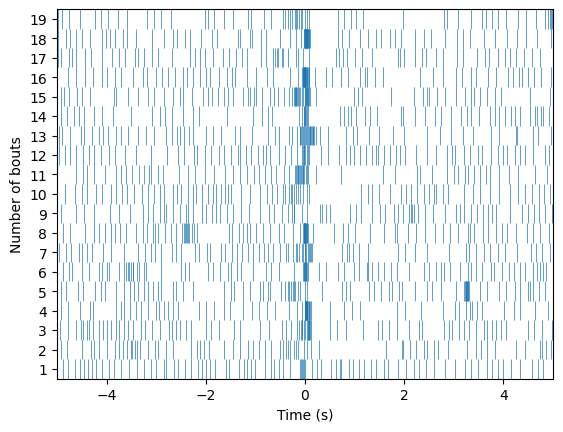

In [6]:
fig, ax = plt.subplots()
time_window = 5  # in seconds

# Iterate over each motor bout
for bout_idx in range(len(start_times)):
    
    bout_start = start_times[bout_idx]
    bout_end = end_times[bout_idx]

    plot_start = bout_start - time_window
    plot_end = bout_start + time_window

    spike_times_within_range = spike_times[(spike_times >= plot_start) & (spike_times <= plot_end)]
    relative_spike_times = spike_times_within_range - bout_start
    ax.vlines(relative_spike_times, bout_idx, bout_idx + 1, linewidths=0.5)


ax.set_ylim(0, len(start_times))
ax.set_yticks(np.arange(len(start_times)) + 0.5,)
ax.set_yticklabels(np.arange(1, len(start_times) + 1))
ax.set_xlim(-time_window, time_window)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Number of bouts')

Since we can see spikes clustering around swim bouts, let's make a peri-event time histogram (PETH) to see it more clearly!

Text(0, 0.5, 'Spike Count')

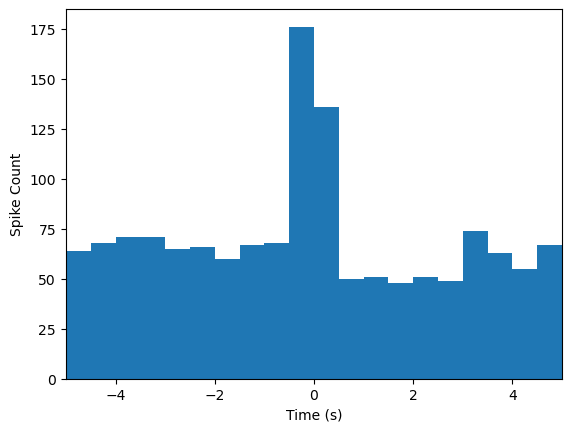

In [7]:
#time window for PETH
time_window_peth = 5  
num_bins = 20 

histogram = np.zeros(num_bins)

# Iterate over each motor bout
for bout_start_peth in start_times:
    hist_start = bout_start_peth - time_window_peth
    hist_end = bout_start_peth + time_window_peth

    spike_times_within_range_peth = spike_times[(spike_times >= hist_start) & (spike_times <= hist_end)]
    relative_spike_times_peth = spike_times_within_range_peth - bout_start_peth
    bins = np.linspace(-time_window_peth, time_window_peth, num_bins + 1)
    histogram += np.histogram(relative_spike_times_peth, bins=bins)[0]


bin_centers = (bins[:-1] + bins[1:]) / 2


fig, ax = plt.subplots()
ax.bar(bin_centers, histogram, width=(2 * time_window_peth / num_bins), align='center')
ax.set_xlim(-time_window_peth, time_window_peth)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Spike Count')


Now we know that eurydendroid cells fire more when the fish is swimming. But what characteristics if the swim are related to eurydendroid cell firing? Let's do a linear regression on swim characteristics with the firing rate of the cell!

In [1]:
from scipy.ndimage import gaussian_filter1d
import statsmodels.api as sm

In [2]:
# Data extraction
start_idxs = motor_bout_data['start_idxs']
end_idxs = motor_bout_data['end_idxs']
spike_idxs = spike_data['peak_idxs']
spike_times = spike_data['peak_times']
start_times= motor_bout_data['start_ms']
end_times= motor_bout_data['end_ms']
episode_strength= motor_bout_data['episode_strength']
burst_frequency = motor_bout_data['burst_frequency']
episode_duration_ms = motor_bout_data['episode_duration_ms']
episode_duration_idxs = motor_bout_data['episode_duration_idxs']

# Input parameters
exp_duration = 300 #seconds
sampling_rate = 20000 #KHz
max_ep_dur = np.max(episode_duration_ms)
# print(spike_times, start_times)

In [3]:
# Spike train
spike_train = np.zeros(exp_duration * sampling_rate)

for peaks in spike_times:
    index = int(peaks * sampling_rate)
    spike_train[index] = 1

In [4]:
# Verification
kappa = np.where(spike_train>0)
print(kappa, spike_idxs)

(array([   2185,    3818,    5853, ..., 5995367, 5998300, 5999324],
      dtype=int64),) [   2185    3818    5853 ... 5995367 5998300 5999324]


In [5]:
def calculate_firing_rate(spike_train, exp_duration, sampling_rate, window_size, sigma):
    '''
    This function calculates the firing rate of the cell from the spike train that we obtained in the begining
    '''
    window_length = int(window_size * sampling_rate)
    spike_counts = np.convolve(spike_train, np.ones(window_length), mode='same')
    firing_rate = spike_counts / window_size

    smoothed_firing_rate = gaussian_filter1d(firing_rate, sigma=sigma, mode='nearest')

    return smoothed_firing_rate

In [6]:
window_size = 0.1  # sliding window size (in seconds)
sigma = 500  # SD for Gaussian smoothing

firing_rate = calculate_firing_rate(spike_train, exp_duration, sampling_rate, window_size, sigma)

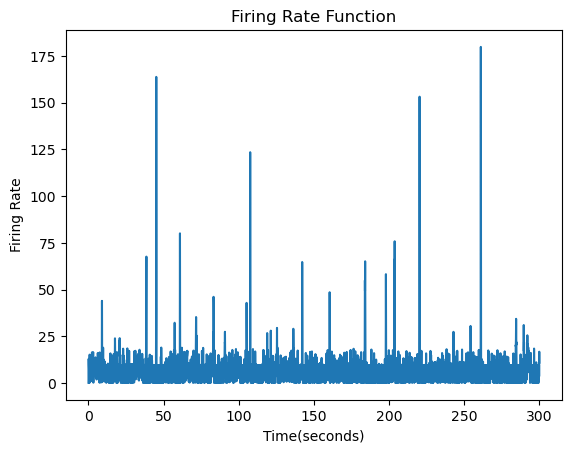

In [7]:
time_axis = np.arange(0, len(firing_rate)) / sampling_rate # To get axis in seconds


plt.plot(time_axis, firing_rate)
plt.xlabel('Time(seconds)')
plt.ylabel('Firing Rate')
plt.title('Firing Rate Function')
# plt.xlim(100,120)
plt.show()

In [8]:
# bout-wise average firing rate
window_size_bout = int(0.3 * sampling_rate)

firing_rate_bouts = []

#mean firing rate in each bout + window
for i in range(len(start_idxs)):
    start_idx = max(start_idxs[i] - window_size_bout, 0)
    end_idx = min(end_idxs[i] + window_size_bout, len(firing_rate))
    bout_firing_rate = firing_rate[start_idx:end_idx]
    average_firing_rate = np.mean(bout_firing_rate)
    firing_rate_bouts.append(average_firing_rate)

firing_rate_bouts = np.array(firing_rate_bouts)
print(len(firing_rate_bouts))

19


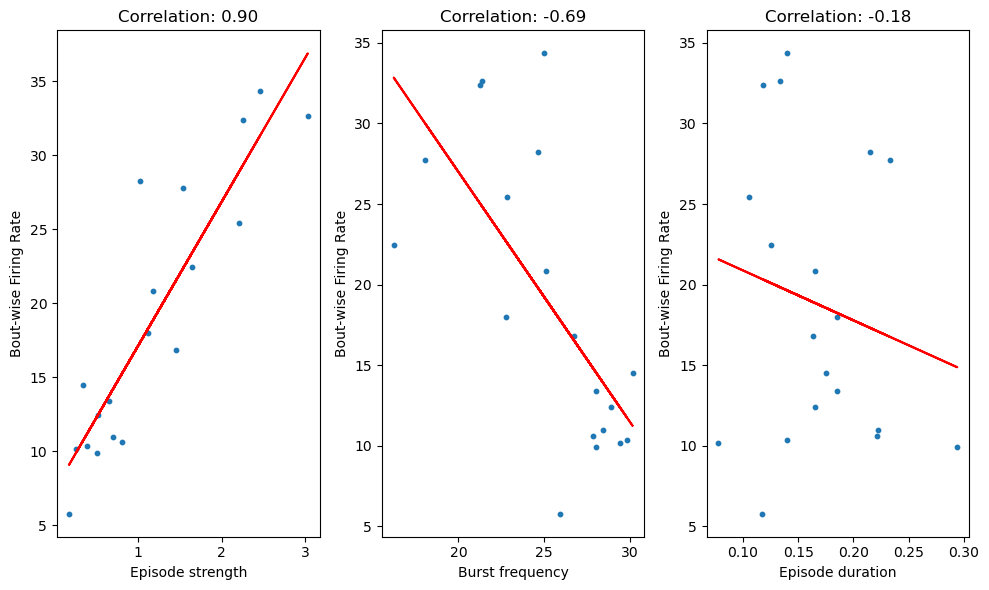

In [14]:
# Calculate correlation coefficients with firing_rate and swim characteristics
corr_coefficients1 = np.corrcoef(episode_strength, firing_rate_bouts)[0, 1]
corr_coefficients2 = np.corrcoef(burst_frequency, firing_rate_bouts)[0, 1]
corr_coefficients3 = np.corrcoef(episode_duration_ms, firing_rate_bouts)[0, 1]


fit1 = np.polyfit(episode_strength, firing_rate_bouts, 1)
fit2 = np.polyfit(burst_frequency, firing_rate_bouts, 1)
fit3 = np.polyfit(episode_duration_ms, firing_rate_bouts, 1)

plt.figure(figsize=(10, 6))
plt.subplot(131)
plt.scatter(episode_strength, firing_rate_bouts, s=10)
plt.plot(episode_strength, np.polyval(fit1, episode_strength), color='red')
plt.xlabel('Episode strength')
plt.ylabel('Bout-wise Firing Rate')
plt.title(f'Correlation: {corr_coefficients1:.2f}')

plt.subplot(132)
plt.scatter(burst_frequency, firing_rate_bouts, s=10)
plt.plot(burst_frequency, np.polyval(fit2, burst_frequency), color='red')
plt.xlabel('Burst frequency')
plt.ylabel('Bout-wise Firing Rate')
plt.title(f'Correlation: {corr_coefficients2:.2f}')

plt.subplot(133)
plt.scatter(episode_duration_ms, firing_rate_bouts, s=10)
plt.plot(episode_duration_ms, np.polyval(fit3, episode_duration_ms), color='red')
plt.xlabel('Episode duration')
plt.ylabel('Bout-wise Firing Rate')
plt.title(f'Correlation: {corr_coefficients3:.2f}')

plt.tight_layout()

The EC cell firing, is highly correlated with the strength of the episode and the burst frequency of the swims!